In [1]:
# import required libraries
# read files
import os
# import torch and related libraries for machine learning
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
import pandas as pd # for data manipulation
from tqdm import tqdm # for iteration 
import matplotlib.pyplot as plt # visualization 
import optuna # type: ignore # optimization 
from sklearn.metrics import accuracy_score
from IPython.core.debugger import set_trace # for debugging

c:\Users\User\anaconda3\envs\ml_win_old\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set seed in torch
torch.manual_seed(235)

# If using CUDA, set seed to CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(235)
    torch.cuda.manual_seed_all(235)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
from torchvision.datasets import MNIST
# read data
training_data = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

In [4]:
# initiate Dataloader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1)

Image shape: torch.Size([28, 28]), Label: 2
Image shape: torch.Size([28, 28]), Label: 7
Image shape: torch.Size([28, 28]), Label: 6
Image shape: torch.Size([28, 28]), Label: 1
Image shape: torch.Size([28, 28]), Label: 7


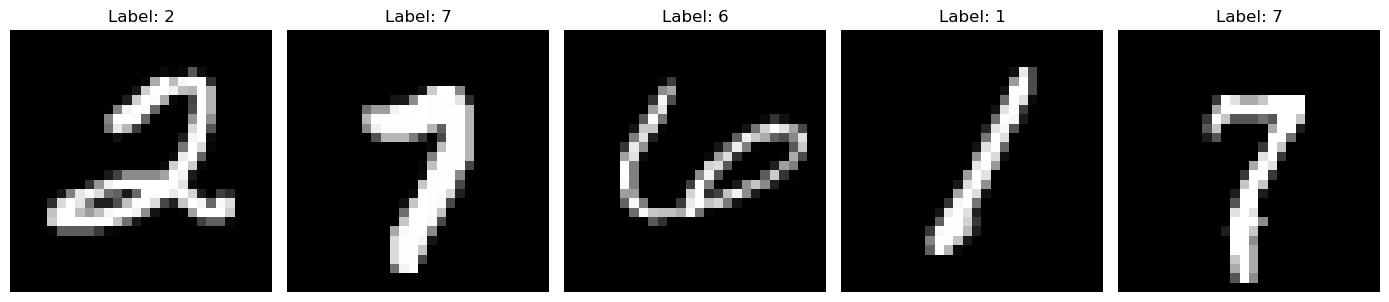

In [5]:
# Data Visualization
plt.figure(figsize=(14, 4))  # Adjust figure size for better visibility
# Iterate through the dataset and print out images, dimensions, and labels
for i, (image, label) in enumerate(train_dataloader):
    if i < 5:
        print(f"Image shape: {image[0][0].shape}, Label: {label[0].item()}")  # Print image shape and label
        
        plt.subplot(1, 5, i + 1)  # Create a subplot
        plt.imshow(image[0].squeeze(), cmap='gray')  # Display the image
        plt.title(f"Label: {label[0].item()}", fontsize=12)  # Add the label as the title
        plt.axis('off')  # Hide axes for better visualization
    else:
        break
plt.tight_layout()
plt.show()

In [10]:
# generic class for MLP
# calling nn.Module

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init=nn.init.xavier_uniform_, 
               loss_fn=nn.CrossEntropyLoss(), opt=torch.optim.Adam, lr=0.0001,
               weight_decay = 0.0, d = None, dropout_prob=None,
               **kwargs
               ): 
        super().__init__() # inherit from nn.Module (base class for all Modules)

        self.input_dim = input_dim
        self.output_dim = output_dim # dimensions for input data and output 
        self.weight_init = weight_init # weight initialization - whether we use xavier or he initialization
        self.loss_fn = loss_fn # loss function
        self.loss_list = list() # store loss values
        self.dropout_prob = dropout_prob # prob for dropout 

        self.layers = nn.Sequential(
        nn.Flatten(),
        self.seq_block(self.input_dim, 64), 
        self.seq_block(64, 128), 
        self.seq_block(128, 256),
        self.seq_block(256, 128),
        self.seq_block(128, 64),
        nn.Linear(64, output_dim)
        ) # instantiate layers

        self.apply(self.init_weights)  # initialize weights 
        
        # optimizer parameters
        self.lr = lr
        self.weight_decay = weight_decay
        self.opt = opt(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    # sequential block 
    def seq_block(self, input_dim_, output_dim_):
        seq_layers = nn.Sequential(
            nn.Linear(input_dim_, output_dim_),
            nn.ReLU(),
            nn.BatchNorm1d(output_dim_)
        )
        if self.dropout_prob:
            seq_layers.append(nn.Dropout(self.dropout_prob))
        return seq_layers
    
    # function to initialize weights
    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            self.weight_init(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    # perform forward pass
    def forward(self, x):
        return self.layers(x)
    
    # loop to fit model
    def fit(self, train_data, epochs=10):
        for i in range(epochs):
            for j, data in enumerate(tqdm(train_data)):
                inputs, targets = data # get inputs
                self.opt.zero_grad() # zero the gradients before backward pass so that we do accumulate gradients from last epoch
                y_pred = self.forward(inputs)
                loss = self.loss_fn(y_pred,targets)
                loss.backward() # perform backward pass
                self.opt.step()  # update weights
                self.loss_list.append(loss.item()) # update current loss
            print(f"Epoch {i+1}: loss = {loss.item()}")
        print("Training Complete")
    
    # switch off gradient calculation for prediction
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)

    def evaluate(self, train_data):
        # set model to eval mode
        self.eval()
        count= 0
        running_corrects = 0
        # loop over data and calculate accuracy (note that we use cross entropy loss to train classifier - 
        # match distribution of class labels with true value) 
        with torch.no_grad():
            for i, data in enumerate(tqdm(train_data)):
                inputs, y_true = data
                y_pred = torch.argmax(self.predict(inputs),dim=1)
                running_corrects += torch.sum(y_pred==y_true)
                count += y_true.shape[0]
        
        accuracy = running_corrects / count
        print(f"Accuracy: {accuracy}")
        return accuracy

In [11]:
# fit the model with default settings
mlp = MLP(input_dim=28*28, output_dim=10)
mlp.fit(train_dataloader, epochs=20)
mlp_test_accuracy = mlp.evaluate(test_dataloader)

100%|██████████| 938/938 [00:12<00:00, 73.94it/s] 


Epoch 1: loss = 0.6008843779563904


100%|██████████| 938/938 [00:12<00:00, 75.15it/s] 


Epoch 2: loss = 0.36336663365364075


100%|██████████| 938/938 [00:11<00:00, 79.80it/s] 


Epoch 3: loss = 0.07769854366779327


100%|██████████| 938/938 [00:11<00:00, 79.45it/s] 


Epoch 4: loss = 0.17223303020000458


100%|██████████| 938/938 [00:11<00:00, 79.19it/s] 


Epoch 5: loss = 0.06586237996816635


100%|██████████| 938/938 [00:11<00:00, 80.06it/s] 


Epoch 6: loss = 0.1253897249698639


100%|██████████| 938/938 [00:11<00:00, 78.87it/s] 


Epoch 7: loss = 0.21034449338912964


100%|██████████| 938/938 [00:12<00:00, 75.95it/s] 


Epoch 8: loss = 0.15304440259933472


100%|██████████| 938/938 [00:11<00:00, 79.32it/s] 


Epoch 9: loss = 0.12905244529247284


100%|██████████| 938/938 [00:11<00:00, 79.39it/s] 


Epoch 10: loss = 0.11209949851036072


100%|██████████| 938/938 [00:12<00:00, 78.05it/s] 


Epoch 11: loss = 0.014982275664806366


100%|██████████| 938/938 [00:11<00:00, 79.12it/s] 


Epoch 12: loss = 0.08779022842645645


100%|██████████| 938/938 [00:12<00:00, 75.90it/s] 


Epoch 13: loss = 0.011673967353999615


100%|██████████| 938/938 [00:13<00:00, 71.09it/s] 


Epoch 14: loss = 0.14586320519447327


100%|██████████| 938/938 [00:12<00:00, 75.18it/s] 


Epoch 15: loss = 0.021577784791588783


100%|██████████| 938/938 [00:11<00:00, 78.63it/s] 


Epoch 16: loss = 0.009951652958989143


100%|██████████| 938/938 [00:12<00:00, 77.96it/s] 


Epoch 17: loss = 0.1354190856218338


100%|██████████| 938/938 [00:11<00:00, 78.66it/s] 


Epoch 18: loss = 0.01249732170253992


100%|██████████| 938/938 [00:12<00:00, 77.34it/s] 


Epoch 19: loss = 0.03543321415781975


100%|██████████| 938/938 [00:12<00:00, 76.58it/s] 


Epoch 20: loss = 0.06565124541521072
Training Complete


100%|██████████| 157/157 [00:04<00:00, 33.33it/s] 

Accuracy: 0.9751999974250793


In [12]:
# function for optuna optimization
def objective(trial):
    # define parameters to optimize
    weight_decay = trial.suggest_float("weight_decay", 0.0001, 100)
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.5)

    mlp = mlp = MLP(input_dim=28*28, output_dim=10, lr=0.0001)
    mlp.fit(train_dataloader, epochs=20) # fit model

    acc = mlp.evaluate(test_dataloader) # evaluate model

    model_path = f"mlp_trials/mlp_trial_{trial.number}.pth"
    torch.save(mlp.state_dict(), model_path) # save model
    trial.set_user_attr("model_path", model_path) # set model path as user attribute
    
    return acc

In [13]:
# Run Optuna optimization
# use grid search
search_space = { "weight_decay" : [2, 5], "dropout_prob" : [0.2, 0.5] } 
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Print the best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-25 17:06:39,164] A new study created in memory with name: no-name-28ce75ab-7eeb-4b20-8a26-b22cb6dcb82a
100%|██████████| 938/938 [00:12<00:00, 76.73it/s] 


Epoch 1: loss = 0.42542120814323425


100%|██████████| 938/938 [00:12<00:00, 75.93it/s] 


Epoch 2: loss = 0.24789299070835114


100%|██████████| 938/938 [00:12<00:00, 76.30it/s] 


Epoch 3: loss = 0.19024261832237244


100%|██████████| 938/938 [00:12<00:00, 75.16it/s] 


Epoch 4: loss = 0.15121623873710632


100%|██████████| 938/938 [00:12<00:00, 75.52it/s] 


Epoch 5: loss = 0.2687479853630066


100%|██████████| 938/938 [00:12<00:00, 76.70it/s] 


Epoch 6: loss = 0.1020408496260643


100%|██████████| 938/938 [00:12<00:00, 76.71it/s] 


Epoch 7: loss = 0.11365070939064026


100%|██████████| 938/938 [00:12<00:00, 78.09it/s] 


Epoch 8: loss = 0.05146043002605438


100%|██████████| 938/938 [00:12<00:00, 76.78it/s] 


Epoch 9: loss = 0.09709926694631577


100%|██████████| 938/938 [00:11<00:00, 78.77it/s] 


Epoch 10: loss = 0.10398910939693451


100%|██████████| 938/938 [00:11<00:00, 78.61it/s] 


Epoch 11: loss = 0.11618690937757492


100%|██████████| 938/938 [00:11<00:00, 78.58it/s] 


Epoch 12: loss = 0.11194179207086563


100%|██████████| 938/938 [00:11<00:00, 78.63it/s] 


Epoch 13: loss = 0.07503536343574524


100%|██████████| 938/938 [00:11<00:00, 78.40it/s] 


Epoch 14: loss = 0.028552986681461334


100%|██████████| 938/938 [00:11<00:00, 79.21it/s] 


Epoch 15: loss = 0.0030673774890601635


100%|██████████| 938/938 [00:11<00:00, 79.15it/s] 


Epoch 16: loss = 0.08142654597759247


100%|██████████| 938/938 [00:12<00:00, 77.91it/s] 


Epoch 17: loss = 0.0858445018529892


100%|██████████| 938/938 [00:12<00:00, 77.40it/s] 


Epoch 18: loss = 0.12711754441261292


100%|██████████| 938/938 [00:12<00:00, 76.16it/s] 


Epoch 19: loss = 0.029798677191138268


100%|██████████| 938/938 [00:12<00:00, 76.44it/s] 


Epoch 20: loss = 0.009735003113746643
Training Complete


100%|██████████| 157/157 [00:04<00:00, 34.92it/s] 
[I 2024-12-25 17:10:46,298] Trial 0 finished with value: 0.9757999777793884 and parameters: {'weight_decay': 2.0, 'dropout_prob': 0.5}. Best is trial 0 with value: 0.9757999777793884.


Accuracy: 0.9757999777793884


100%|██████████| 938/938 [00:12<00:00, 77.48it/s] 


Epoch 1: loss = 0.659567654132843


100%|██████████| 938/938 [00:12<00:00, 73.63it/s] 


Epoch 2: loss = 0.3179216682910919


100%|██████████| 938/938 [00:13<00:00, 70.38it/s] 


Epoch 3: loss = 0.14665958285331726


100%|██████████| 938/938 [00:13<00:00, 68.68it/s] 


Epoch 4: loss = 0.42519450187683105


100%|██████████| 938/938 [00:12<00:00, 72.84it/s] 


Epoch 5: loss = 0.22597120702266693


100%|██████████| 938/938 [00:13<00:00, 72.09it/s] 


Epoch 6: loss = 0.18246500194072723


100%|██████████| 938/938 [00:12<00:00, 74.23it/s] 


Epoch 7: loss = 0.06519961357116699


100%|██████████| 938/938 [00:13<00:00, 69.37it/s] 


Epoch 8: loss = 0.11392175406217575


100%|██████████| 938/938 [00:13<00:00, 69.85it/s] 


Epoch 9: loss = 0.027706213295459747


100%|██████████| 938/938 [00:14<00:00, 65.95it/s] 


Epoch 10: loss = 0.08578076958656311


100%|██████████| 938/938 [00:12<00:00, 73.07it/s] 


Epoch 11: loss = 0.07133949548006058


100%|██████████| 938/938 [00:13<00:00, 72.01it/s] 


Epoch 12: loss = 0.021315893158316612


100%|██████████| 938/938 [00:12<00:00, 72.47it/s] 


Epoch 13: loss = 0.2526566684246063


100%|██████████| 938/938 [00:12<00:00, 73.65it/s] 


Epoch 14: loss = 0.056807488203048706


100%|██████████| 938/938 [00:12<00:00, 73.27it/s] 


Epoch 15: loss = 0.08828222751617432


100%|██████████| 938/938 [00:13<00:00, 70.91it/s] 


Epoch 16: loss = 0.08411416411399841


100%|██████████| 938/938 [00:13<00:00, 72.12it/s] 


Epoch 17: loss = 0.04412597417831421


100%|██████████| 938/938 [00:12<00:00, 73.66it/s] 


Epoch 18: loss = 0.07811427861452103


100%|██████████| 938/938 [00:12<00:00, 73.45it/s] 


Epoch 19: loss = 0.006330221425741911


100%|██████████| 938/938 [00:12<00:00, 76.16it/s] 


Epoch 20: loss = 0.053129516541957855
Training Complete


100%|██████████| 157/157 [00:04<00:00, 33.06it/s] 
[I 2024-12-25 17:15:11,053] Trial 1 finished with value: 0.9757999777793884 and parameters: {'weight_decay': 5.0, 'dropout_prob': 0.5}. Best is trial 0 with value: 0.9757999777793884.


Accuracy: 0.9757999777793884


100%|██████████| 938/938 [00:12<00:00, 76.50it/s] 


Epoch 1: loss = 0.4692807197570801


100%|██████████| 938/938 [00:12<00:00, 77.00it/s] 


Epoch 2: loss = 0.43846845626831055


100%|██████████| 938/938 [00:14<00:00, 66.56it/s] 


Epoch 3: loss = 0.15079163014888763


100%|██████████| 938/938 [00:13<00:00, 69.91it/s] 


Epoch 4: loss = 0.14818152785301208


100%|██████████| 938/938 [00:12<00:00, 76.53it/s] 


Epoch 5: loss = 0.16590483486652374


100%|██████████| 938/938 [00:12<00:00, 75.22it/s] 


Epoch 6: loss = 0.03413102775812149


100%|██████████| 938/938 [00:12<00:00, 77.98it/s] 


Epoch 7: loss = 0.11540334671735764


100%|██████████| 938/938 [00:12<00:00, 78.09it/s] 


Epoch 8: loss = 0.04879172891378403


100%|██████████| 938/938 [00:12<00:00, 77.43it/s] 


Epoch 9: loss = 0.11497491598129272


100%|██████████| 938/938 [00:11<00:00, 78.66it/s] 


Epoch 10: loss = 0.12717129290103912


100%|██████████| 938/938 [00:12<00:00, 77.91it/s] 


Epoch 11: loss = 0.03932204097509384


100%|██████████| 938/938 [00:12<00:00, 75.91it/s] 


Epoch 12: loss = 0.005025014281272888


100%|██████████| 938/938 [00:11<00:00, 78.37it/s] 


Epoch 13: loss = 0.028053732588887215


100%|██████████| 938/938 [00:11<00:00, 78.49it/s] 


Epoch 14: loss = 0.017107704654335976


100%|██████████| 938/938 [00:12<00:00, 77.95it/s] 


Epoch 15: loss = 0.12009281665086746


100%|██████████| 938/938 [00:12<00:00, 77.04it/s] 


Epoch 16: loss = 0.00707461079582572


100%|██████████| 938/938 [00:11<00:00, 78.47it/s] 


Epoch 17: loss = 0.042801305651664734


100%|██████████| 938/938 [00:12<00:00, 76.49it/s] 


Epoch 18: loss = 0.005153465550392866


100%|██████████| 938/938 [00:11<00:00, 78.68it/s] 


Epoch 19: loss = 0.033499106764793396


100%|██████████| 938/938 [00:12<00:00, 77.91it/s] 


Epoch 20: loss = 0.005164258647710085
Training Complete


100%|██████████| 157/157 [00:04<00:00, 34.79it/s] 
[I 2024-12-25 17:19:21,092] Trial 2 finished with value: 0.9750000238418579 and parameters: {'weight_decay': 5.0, 'dropout_prob': 0.2}. Best is trial 0 with value: 0.9757999777793884.


Accuracy: 0.9750000238418579


100%|██████████| 938/938 [00:12<00:00, 78.12it/s] 


Epoch 1: loss = 0.3892158567905426


100%|██████████| 938/938 [00:11<00:00, 79.42it/s] 


Epoch 2: loss = 0.25283873081207275


100%|██████████| 938/938 [00:11<00:00, 78.80it/s] 


Epoch 3: loss = 0.08984880149364471


100%|██████████| 938/938 [00:12<00:00, 76.74it/s] 


Epoch 4: loss = 0.16380243003368378


100%|██████████| 938/938 [00:12<00:00, 78.16it/s] 


Epoch 5: loss = 0.22854940593242645


100%|██████████| 938/938 [00:12<00:00, 76.69it/s] 


Epoch 6: loss = 0.06209782510995865


100%|██████████| 938/938 [00:11<00:00, 78.35it/s] 


Epoch 7: loss = 0.03596913069486618


100%|██████████| 938/938 [00:11<00:00, 78.70it/s] 


Epoch 8: loss = 0.291554719209671


100%|██████████| 938/938 [00:12<00:00, 77.82it/s] 


Epoch 9: loss = 0.040071092545986176


100%|██████████| 938/938 [00:11<00:00, 78.98it/s] 


Epoch 10: loss = 0.10547889769077301


100%|██████████| 938/938 [00:11<00:00, 78.52it/s] 


Epoch 11: loss = 0.021724773570895195


100%|██████████| 938/938 [00:11<00:00, 78.25it/s] 


Epoch 12: loss = 0.11304596066474915


100%|██████████| 938/938 [00:12<00:00, 78.16it/s] 


Epoch 13: loss = 0.25039246678352356


100%|██████████| 938/938 [00:11<00:00, 78.61it/s] 


Epoch 14: loss = 0.06634867936372757


100%|██████████| 938/938 [00:11<00:00, 78.33it/s] 


Epoch 15: loss = 0.03752429783344269


100%|██████████| 938/938 [00:11<00:00, 79.28it/s] 


Epoch 16: loss = 0.13196788728237152


100%|██████████| 938/938 [00:11<00:00, 78.34it/s] 


Epoch 17: loss = 0.01064323354512453


100%|██████████| 938/938 [00:11<00:00, 78.78it/s] 


Epoch 18: loss = 0.027049804106354713


100%|██████████| 938/938 [00:12<00:00, 76.58it/s] 


Epoch 19: loss = 0.08335525542497635


100%|██████████| 938/938 [00:12<00:00, 77.61it/s] 


Epoch 20: loss = 0.03728038817644119
Training Complete


100%|██████████| 157/157 [00:04<00:00, 33.39it/s] 
[I 2024-12-25 17:23:25,738] Trial 3 finished with value: 0.9764999747276306 and parameters: {'weight_decay': 2.0, 'dropout_prob': 0.2}. Best is trial 3 with value: 0.9764999747276306.


Accuracy: 0.9764999747276306
Best trial:
  Value: 0.9764999747276306
  Params: 
    weight_decay: 2.0
    dropout_prob: 0.2


In [14]:
# After the study completes
best_trial = study.best_trial

# Retrieve the path to the best model
best_model_path = best_trial.user_attrs["model_path"]

# Reload the best model
best_mlp = MLP(input_dim=28*28, output_dim=10)
best_mlp.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>